## Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install hazm

In [6]:
#@title
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import collections
import re

import datetime
from datetime import timedelta

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score
from scipy import sparse



from gensim import models, corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from hazm import *
from sklearn.metrics.pairwise import linear_kernel

from numpy import dot
from numpy.linalg import norm
from nltk.tokenize import word_tokenize
import random

# import fasttext
# import fasttext.util
# from gensim.models import FastText as fText



In [ ]:
# !pip install fasttext

In [ ]:
# fasttext.util.download_model('fa', if_exists='ignore')  # farsi
# ft = fasttext.load_model('cc.fa.300.bin')

## Process the Data

In [8]:
def remove_hashtag(dataset):
  s=[]
  t=[]
  for i in dataset["tweet"]:
    s.append([j.strip("#") for j in i.split() if j.startswith("#")])
    hash_pattern=re.compile("\#[\w\_]+")
    t.append(re.sub(hash_pattern,"",i))
  dataset["hashtags"]=s
  dataset["tweet"]=t
  return dataset

def pre_process1(text):

    text = ' '.join(x for x in text.split() if x.startswith('http') == False and x.startswith('www') == False)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^www?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # extra step to make sure html tags are completely removed
    clean = re.compile('<.*>|<.*\"')
    text = re.sub(clean, '', text)
    text = re.sub("(pic.*)","", text)
    text = re.sub(r"http\S+","", text)
    text = re.sub("(twitter.*)","", text)
    text=re.sub("<!--?.*?-->","",text)
    text = re.sub("(dlvr.*)","", text)
    text=text.replace(u'\u200c'," ")

    return text

def pre_process2(text,time,marks,hashtags):

    list1=[]
    time1=[]
    marks1=[]
    hashtags1=[]
    for k,i in enumerate(text):
      a=sent_tokenize(i)
      for j in a:
        j=re.sub("(\\d|\\W)+"," ",j)
        if j!=None:
          list1.append(j)
          time1.append(time[k])
          marks1.append(marks[k])
          hashtags1.append(hashtags[k])

    return list1,time1,marks1,hashtags1


def pre_process3(text,time,marks,hashtags):
  for i in text:
    mask=text==i
    if len(text[mask])>=3:
      mask2=text!=i
      text=text[mask2]
      time=time[mask2]
      marks=marks[mask2]
      hashtags=hashtags[mask2]
  return text,time,marks,hashtags

def find_marks(text):
  m_list=[]
  for i in text:
    # print(i)
    if "؟" in i:
      m_list.append(1)
    elif "!" in i:
       m_list.append(1)
    elif "?" in i:
      m_list.append(1)
    else:
      m_list.append(0)
  return m_list


In [ ]:
def get_stop_words(stop_file_path):

    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

stopwords=get_stop_words("/content/drive/My Drive/Fake news pro/step2.1/stopwords.dat")
newstopwords = ["_ir" ,"bbc" ,"bit" ,"com" ,"dgto" ,"eghtesadnews" ,"fa","http" ,"https","in" ,"ir" ,"ly" ,"news" ,"status" ,"tejaratnews","tiny","twitter","www","استhttp","ها" ,"های","شدhttps","شدhttp"]
initial_stopwords = list(stopwords)

mod_stop_words = initial_stopwords + newstopwords

## TF_IDF

In [ ]:
def time_finder(min_time,time):
  datetimeFormat = '%Y-%m-%d %H:%M:%S'
  d_t=datetime.datetime.strptime(str(time), datetimeFormat)- datetime.datetime.strptime(str(min_time), datetimeFormat)
  return abs(d_t.days)


def check_similarity(test_data,test_time,total_data,total_time,similar_rate,types,c_time):
  tweet_number=test_data.shape[0]
  label_dic=[]
  for i in range(tweet_number):
    min_time=test_time[i]
    mask=[time_finder(min_time,time)<c_time for time in total_time]
    a=[i for i in range(len(mask)) if mask[i]==True]
    A=total_data
    A=A.tocsr()[a,:]
  
    cosine_similarities = linear_kernel(test_data[i], A).flatten()
    
    if types==0:
      maskk=cosine_similarities>similar_rate
      length=len(cosine_similarities[maskk])+1
      related_docs_indices = cosine_similarities.argsort()[:-1*length:-1]
      if length>2:
        label_dic.append([a[x] for x in related_docs_indices])

    else:
      related_docs_indices = cosine_similarities.argsort()[:-2:-1]
      max_similar=np.min(cosine_similarities[related_docs_indices])
      if max_similar > similar_rate:
        label_dic.append([i,a[related_docs_indices[0]]])
  if types==0:
    from itertools import combinations 
    ss=[]
    for i in label_dic:
      y=list(combinations(i,2))
      ss.append([x for x in y])

    import itertools
    ss=list(itertools.chain.from_iterable(ss))
    idx = np.r_[ss].T
    label_dic=[list(i) for i in ss]

  return np.array(label_dic)

In [ ]:
def labeling(dataset,total_data,labels,types,startpoint):

  labb=[]
  if types==0:
    for i in range(len(dataset["tweet"])):
      mask1=labels[:,0]==i
      mask2=labels[:,1]==i
      list1=labels[mask1,1]
      list2=labels[mask2,0]
      list3=np.concatenate((list1, list2,[i]))
      list3=list(set(list3))
      labb.append(list3)
    dataset["label"]=np.arange(len(dataset["tweet"]))+np.array(startpoint)
    for i in range(len(dataset["tweet"])):
      for j in labb[i]:
        dataset["label"][j]=dataset["label"][i]
  else:
    for i in range(len(dataset["tweet"])):
      mask1=labels[:,0]==i
      list1=labels[mask1,1]
      labb.append(list1)
    dataset["label"]=np.arange(len(dataset["tweet"]))+np.array(startpoint)
    for i in range(len(dataset["tweet"])):
      for j in labb[i]:
        dataset["label"][i]=total_data["label"][j]

  return dataset

## Making the Total Data

In [ ]:
pd.set_option('display.max_colwidth',2000)

In [ ]:
data_bbc = pd.read_json("/content/drive/My Drive/Fake news pro/similarity/data/BBCpersian.json",lines=True)
data_bbc = data_bbc.filter(items = ["tweet","created_at"])

data_bbc["marks"]=find_marks(data_bbc["tweet"].tolist())
data_bbc=remove_hashtag(data_bbc)

data_bbc["tweet"] = data_bbc["tweet"].apply(lambda x:pre_process1(x))
a,b,c,d=pre_process2(data_bbc["tweet"],data_bbc["created_at"],data_bbc["marks"],data_bbc["hashtags"])
a,b,c,d=pre_process3(np.array(a),np.array(b),np.array(c),np.array(d))
d_bbc= pd.DataFrame()
data_b = pd.DataFrame({"tweet":a,"time":b,"marks":c,"hashtags":d})
d_bbc= d_bbc.append(data_b)


cv = TfidfVectorizer(stop_words=mod_stop_words)
docs_bbc=d_bbc["tweet"].tolist()
total_tweets_bbc = cv.fit_transform(docs_bbc)
bbc_time=d_bbc["time"].tolist()
bbc_time=np.array(bbc_time)

labels=check_similarity(total_tweets_bbc,bbc_time,total_tweets_bbc,bbc_time,0.8,0,2)
d_bbc=labeling(d_bbc,d_bbc,labels,0,0)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'گوید', 'گویند'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
d_bbc[:10]

,tweet,time,marks,hashtags,label
0,کرونا باعث لغو بسیاری از جشن ها کنسرت ها و مهمانی ها در سراسر جهان شده است,2020-08-03 11:40:20,0,[],0
1,اما برنامه گذاران هم بیکار ننشسته اند و با وجود محدودیت ها جایگزین هایی برای اجرای کنسرت و جشن پیدا کرده اند حالا برای اولین بار یک دیسکوی ایرانی در سینمای ماشین روی شهر دوسلدورف آلمان برگزار شد,2020-08-03 11:40:20,0,[],1
2,بنا بر این داده ها در بهمن نفر با علایم مربوط به کرونا به مراکز درمانی ایران مراجعه کردند,2020-08-03 10:59:33,0,[],2
3,به نظر می رسد ثبت متمرکز اطلاعات بیماران احتمالی کرونا که مطابق اطلاعات رسیده به بی بی سی فارسی اوایل اسفند آغاز شده تا بهمن عقب می رود,2020-08-03 10:59:33,0,[],3
4,این اطلاعات هم جهت با برآوردهایی است که بی بی سی پیشتر بر اساس مطالعات همه گیرشناسان از زمان ورود احتمالی ویروس کرونا به ایران گزارش کرده بود,2020-08-03 10:59:33,0,[],4
5,پزشکان مطلع در ایران می گویند فشارهای امنیتی باعث شد تشخیص قطعی اولین مبتلایان کرونا و اعلام ورود این ویروس به ایران به تاخیر بیفتد,2020-08-03 10:59:33,0,[],5
6,داده های پزشکی و فهرست هایی از موارد قطعی و مشکوک به در ایران به بی بی سی فارسی رسیده که حاکی از پنهانکاری و لاپوشانی آغاز شیوع کرونا در ایران است,2020-08-03 10:59:33,0,"[کووید۱۹, کرونا]",6
7,بنا بر این اطلاعات اولین تاریخ فوت این فهرست بهمن حدود یک ماه قبل از تایید رسمی اولین مورد در ایران بود,2020-08-03 10:59:33,0,"[کووید۱۹, کرونا]",7
8,درز آمار کرونا پنهانکاری یک ماهه ایران را فاش می کند فشارهای امنیتی دلیل تاخیر بود,2020-08-03 10:41:08,0,[],8
9,اخبار جعلی چطور خبرهای جعلی را تشخیص دهیم,2020-08-03 09:42:51,1,[],9


In [ ]:
data_euro = pd.read_json("/content/drive/My Drive/Fake news pro/similarity/data/Euronews.json",lines=True)
data_euro = data_euro.filter(items = ["tweet","created_at"])

data_euro["marks"]=find_marks(data_euro["tweet"].tolist())
data_euro=remove_hashtag(data_euro)
data_euro["tweet"] = data_euro["tweet"].apply(lambda x:pre_process1(x))
a,b,c,d=pre_process2(data_euro["tweet"],data_euro["created_at"],data_euro["marks"],data_euro["hashtags"])
a,b,c,d=pre_process3(np.array(a),np.array(b),np.array(c),np.array(d))
d_euro= pd.DataFrame()
data_e = pd.DataFrame({"tweet":a,"time":b,"marks":c,"hashtags":d})
d_euro= d_euro.append(data_e)


docs_euro=d_euro["tweet"].tolist()
total_tweets_euro = cv.transform(docs_euro)
euro_time=d_euro["time"].tolist()
euro_time=np.array(euro_time)

labels=check_similarity(total_tweets_euro,euro_time,total_tweets_bbc,bbc_time,0.65,1,15)

d_euro=labeling(d_euro,d_bbc,labels,1,2000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# d_euro

In [ ]:
d_total=d_bbc.append(d_euro,ignore_index=True, sort=False)
total_time=np.array(d_total["time"].tolist())
docs_total=d_total["tweet"].tolist()
total_tweets_total=cv.transform(docs_total)

In [ ]:
data_int = pd.read_json("/content/drive/My Drive/Fake news pro/similarity/data/IranInt.json",lines=True)
data_int = data_int.filter(items = ["tweet","created_at"])

data_int["marks"]=find_marks(data_int["tweet"].tolist())
data_int=remove_hashtag(data_int)
data_int["tweet"] = data_int["tweet"].apply(lambda x:pre_process1(x))
a,b,c,d=pre_process2(data_int["tweet"],data_int["created_at"],data_int["marks"],data_int["hashtags"])
a,b,c,d=pre_process3(np.array(a),np.array(b),np.array(c),np.array(d))
d_int= pd.DataFrame()
data_i = pd.DataFrame({"tweet":a,"time":b,"marks":c,"hashtags":d})
d_int= d_int.append(data_i)


docs_int=d_int["tweet"].tolist()
total_tweets_int = cv.transform(docs_int)
int_time=d_int["time"].tolist()
int_time=np.array(int_time)

labels=check_similarity(total_tweets_int,int_time,total_tweets_total,total_time,0.65,1,15)

d_int=labeling(d_int,d_total,labels,1,4000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# d_int

In [ ]:
d_total=d_total.append(d_int,ignore_index=True, sort=False)
total_time=np.array(d_total["time"].tolist())
docs_total=d_total["tweet"].tolist()
total_tweets_total=cv.transform(docs_total)

In [ ]:
data_voa = pd.read_json("/content/drive/My Drive/Fake news pro/similarity/data/VOAIran.json",lines=True)
data_voa = data_voa.filter(items = ["tweet","created_at"])

data_voa["marks"]=find_marks(data_voa["tweet"].tolist())
data_voa=remove_hashtag(data_voa)
data_voa["tweet"] = data_voa["tweet"].apply(lambda x:pre_process1(x))
a,b,c,d=pre_process2(data_voa["tweet"],data_voa["created_at"],data_voa["marks"],data_voa["hashtags"])
a,b,c,d=pre_process3(np.array(a),np.array(b),np.array(c),np.array(d))
d_voa= pd.DataFrame()
data_v = pd.DataFrame({"tweet":a,"time":b,"marks":c,"hashtags":d})
d_voa= d_voa.append(data_v)


docs_voa=d_voa["tweet"].tolist()
total_tweets_voa = cv.transform(docs_voa)
voa_time=d_voa["time"].tolist()
voa_time=np.array(voa_time)

labels=check_similarity(total_tweets_voa,voa_time,total_tweets_total,total_time,0.65,1,15)

d_voa=labeling(d_voa,d_total,labels,1,6000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
d_voa

,tweet,time,marks,hashtags,label
0,مایک پمپئو می گوید اپلیکیشن های چینی اطلاعات کاربران را مستقیما به حزب کمونیست چین منتقل می کنند,2020-08-03 01:28:23,0,[],6000
1,پژوهش دانشگاه ییل آمریکا درباره نقش تنفس صحیح در بهبود سلامت روانی,2020-08-02 20:20:39,0,[],6001
2,وزیر امور خارجه از دولت خواست در امور کشورهای عرب دخالت نکند به گزارش خبرگزاری رویترز انور قرقاش در پیامی در توئیتر نوشت روابط با تهدید مدیریت نمی شوند و در این روزها و در این عصر جایی برای توهمات استعماری نیست,2020-08-02 20:18:30,0,"[امارات, ترکیه]",6002
3,مایک دولت مرتکب بزرگترین نقض در قرن حاضر شده است وزیر خارجه ایالات متحده با اشاره به موارد نقض حقوق بشر توسط دولت چین و زیر پا گذاشتن حقوق اقلیت های قومی و مذهبی ساکن در ژین ژیانگ گفت خطر بزرگی مردم آن منطقه را تهدید کرده و می کند,2020-08-02 19:59:39,0,"[پمپئو:, چین, حقوق_بشر]",6003
4,موفقیتی تاریخی در صنعت فضانوردی فضانوردان ناسا با کپسول درگن در آب های خلیج مکزیک فرود آمدند,2020-08-02 19:39:01,0,[آمریکا؛],6004
...,...,...,...,...,...
1192,اینفوگرافیک مقایسه تعداد مبتلایان و جان باختگان بر اثر در کشورها آمار تا چهارشنبه تیرماه است آمار رسمی و قابل راستی آزمایی توسط کارشناسان مستقل نیست و نمی تواند معتبر و نهایی تلقی شود,2020-07-01 13:43:55,0,"[کرونا, چین،, روسیه, ایران]",7192
1193,صحت آمار اعلام شده توسط جمهوری اسلامی همچون آمارهای چین و روسیه به شدت مورد تردید است و سازمان بهداشت جهانی و حتی مرکز پژوهش های مجلس شورای اسلامی اعلام کرده اند که آمار واقعی ابتلا و مرگ چند برابر آمار رسمی در ایران است,2020-07-01 13:36:23,0,[],7193
1194,برایان گزینه نظامی در مورد برنامه هسته ای همواره روی میز است آقای هوک افزود مردم و مردم آمریکا و جامعه جهانی باید بدانند که پرزیدنت هرگز به آن ها اجازه داشتن یک سلاح هسته ای را نخواهد داد,2020-07-01 13:00:34,0,"[هوک:‌, ایران, اسرائیل, ترامپ]",7194
1195,سخنگوی کاخ سفید پرزیدنت دستور کشتن را برای حفاظت از نیروهای در منطقه صادر کرده بود سخنگوی کاخ سفید کشتن قاسم سلیمانی را یکی از اقدامات مهم پرزیدنت ترامپ در حفاظت از نیروهای آمریکایی در خارج از این کشور دانست,2020-07-01 00:22:20,0,"[ترامپ, قاسم_سلیمانی, آمریکایی]",7195


In [ ]:
d_total=d_total.append(d_voa,ignore_index=True, sort=False)

In [ ]:
x=0
label_list=list(set(d_total["label"])) 
for l in label_list:
  mask=d_total["label"]==l
  d_total["label"][mask]=[x]*len(mask[mask==True])
  x+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# d_total

In [ ]:
label_list=list(set(d_total["label"])) 
for l in label_list:
  mask=d_total["label"]==l
  if len(mask[mask==True])<2:
    d_total.drop(d_total[d_total["label"]==l].index, inplace = True) 
    d_total = d_total.reset_index(drop=True)

In [ ]:
d_total

,tweet,time,marks,hashtags,label
0,اعتصاب های گسترده کارگران صنعت نفت در ایران کارگران صنایع نفت و گاز در جنوب ایران در اعتراض به شرایط سخت کار و نبود امکانات ایمنی و رفاهی و همچنین پرداخت نشدن به موقع مزایا اعتصاب کرده اند,2020-08-02 18:01:56,0,[],29
1,گفتگویی با ستار رحمانی فعال کارگری بخش دوم,2020-08-02 18:01:56,0,[],30
2,اعتصاب های گسترده کارگران صنعت نفت در ایران کارگران صنایع نفت و گاز در جنوب ایران در اعتراض به شرایط سخت کار و نبود امکانات ایمنی و رفاهی و همچنین پرداخت نشدن به موقع مزایا اعتصاب کرده اند,2020-08-02 18:01:41,0,[],29
3,گفتگویی با ستار رحمانی فعال کارگری بخش اول,2020-08-02 18:01:41,0,[],30
4,کرونا و کنکور در ایران مخالفان برپایی کنکور می گویند که این آزمون ممکن است سلامت داوطلبان را به خطر بیندازد,2020-08-02 15:57:17,0,[],42
...,...,...,...,...,...
291,ادیب ولی دانش آموز بهایی پایه دهم روز چهارشنبه تیر از تحصیل در مدرسه سلام البرز کرج محروم شد,2020-07-09 14:47:11,0,[],1007
292,بیست و یکمین روز و کارگران نیشکر تپه,2020-07-05 14:00:35,0,"[اعتراضات, اعتصاب, هفت‌تپه]",3328
293,استعفای نخست وزیر و انتصاب نخست وزیر جدید از سوی امانوئل ماکرون,2020-07-04 19:39:00,0,[فرانسه],3467
294,این عملیات بخشی از پروژه نوسازی ایستگاه است و اهمیت زیادی دارد,2020-07-03 14:09:14,0,"[آمریکایی, فضایی]",3068


In [ ]:
x=0
label_list=list(set(d_total["label"])) 
for l in label_list:
  mask=d_total["label"]==l
  d_total["label"][mask]=[x]*len(mask[mask==True])
  x+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
d_total[:20]

,tweet,time,marks,hashtags,label
0,اعتصاب های گسترده کارگران صنعت نفت در ایران کارگران صنایع نفت و گاز در جنوب ایران در اعتراض به شرایط سخت کار و نبود امکانات ایمنی و رفاهی و همچنین پرداخت نشدن به موقع مزایا اعتصاب کرده اند,2020-08-02 18:01:56,0,[],3
1,گفتگویی با ستار رحمانی فعال کارگری بخش دوم,2020-08-02 18:01:56,0,[],4
2,اعتصاب های گسترده کارگران صنعت نفت در ایران کارگران صنایع نفت و گاز در جنوب ایران در اعتراض به شرایط سخت کار و نبود امکانات ایمنی و رفاهی و همچنین پرداخت نشدن به موقع مزایا اعتصاب کرده اند,2020-08-02 18:01:41,0,[],3
3,گفتگویی با ستار رحمانی فعال کارگری بخش اول,2020-08-02 18:01:41,0,[],4
4,کرونا و کنکور در ایران مخالفان برپایی کنکور می گویند که این آزمون ممکن است سلامت داوطلبان را به خطر بیندازد,2020-08-02 15:57:17,0,[],8
5,گفتگویی با روجا اسدی,2020-08-02 15:57:17,0,[],9
6,کارگران پالایشگاه های نفت سنگین قشم پارسیان لامرد پالایشگاه آبادان و فازهای و پارس جنوبی از روز مرداد دست از کار کشیده اند,2020-08-02 15:00:59,0,[],10
7,اسناد محرمانه ارتش بریتانیا سوال های تازه ای را در مورد احتمال تلاش نیروهای ویژه این کشور برای پنهان کاری درباره کشتن غیرنظامیان در افغانستان مطرح می کند,2020-08-02 14:20:06,0,[],14
8,اسناد محرمانه ارتش بریتانیا سوال های تازه ای را در مورد احتمال تلاش نیروهای ویژه این کشور برای پنهان کاری درباره کشتن غیرنظامیان در افغانستان مطرح می کند گفته شده نیروهای ارتش بریتانیا سیاست کشتن عمدی مردان جنگجوی سالخورده را دنبال می کردند,2020-08-02 13:19:24,0,[],14
9,مخالفان برپایی کنکور می گویند که با توجه به شیوع کرونا این آزمون ممکن است سلامت داوطلبان را به خطر بیندازد,2020-08-02 12:50:07,0,[],8


In [ ]:
total_time=np.array(d_total["time"].tolist())
docs_total=d_total["tweet"].tolist()
total_tweets_total=cv.fit_transform(docs_total)

In [ ]:
# d_total
data_arab = pd.read_json("/content/drive/My Drive/Fake news pro/similarity/tweets (28).json",lines=True)
data_arab = data_arab.filter(items = ["tweet","created_at"])

In [ ]:
data_arab["marks"]=find_marks(data_arab["tweet"].tolist())
data_arab=remove_hashtag(data_arab)

In [ ]:
data_arab["tweet"] = data_arab["tweet"].apply(lambda x:pre_process1(x))
a,b,c,d=pre_process2(data_arab["tweet"],data_arab["created_at"],data_arab["marks"],data_arab["hashtags"])
a,b,c,d=pre_process3(np.array(a),np.array(b),np.array(c),np.array(d))

In [ ]:
d_arab= pd.DataFrame()
# kj={"tweet":a,"time":b,"marks":c,"hashtags":d}
# data_a = pd.DataFrame(kj)
list_of_tuples = list(zip(a,b,c,d))  
  
df = pd.DataFrame(list_of_tuples, columns = ['tweet', 'time','marks','hashtags']) 

In [ ]:
d_arab= d_arab.append(df)

In [ ]:

docs_arab=d_arab["tweet"].tolist()
total_tweets_arab = cv.transform(docs_arab)
arab_time=d_arab["time"].tolist()
arab_time=np.array(arab_time)

labels=check_similarity(total_tweets_arab,arab_time,total_tweets_total,total_time,0.5,1,15)

d_arab=labeling(d_arab,d_total,labels,1,6000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# labels

In [ ]:
d_true=d_arab[d_arab["label"]<6000]

In [ ]:
d_true

,tweet,time,marks,hashtags,label
9,لیلاز ما برای زنده ماندن در مقابل فشارهای آمریکا باید با چین قرارداد ساله ببندیم,2020-07-29 14:55:41,0,[],107
12,طالبان سه روز عید را آتش بس اعلام کردند,2020-07-29 14:48:59,0,[],79
35,کیو ا نان طرفداری از دونالد ترامپ با استفاده از تئوری توطئه,2020-07-27 20:41:05,0,[],67
37,برقراری یک آتش بس جدید در شرق اوکراین,2020-07-27 20:32:51,0,[],79
62,تنش میان پکن و واشنگتن چین دستور تعطیلی کنسولگری آمریکا در چنگدو را صادر کرد,2020-07-24 14:29:36,0,[],115
67,شمار جان باختگان کرونا در ایران از مرز هزار نفر فراتر رفت عزاداری های محرم با رعایت پروتکل,2020-07-23 16:20:38,0,[],109
83,بازخوانی داده های جعبه های سیاه هواپیمای مسافربری اوکراینی به پایان رسید اوکراین ادعای ایران مبنی بر خطای انسانی را نمی پذیرد,2020-07-21 17:39:34,0,[],58
84,فیگارو اتحاد چین و ایران یک چرخش بزرگ در صحنه شطرنج جهانی,2020-07-21 17:37:06,0,[],107
88,در اقدامی تلافی جویانه یک خواهر و برادر نوجوان دو جنگجوی طالبان را کشتند,2020-07-21 17:00:19,0,[],129
89,تغییر نظر دونالد ترامپ در مورد ماسک نتیجۀ تغییر استراتژی انتخاباتی,2020-07-21 16:59:16,1,[],67


In [ ]:
d_true.to_json(r"/content/drive/My Drive/Fake news pro/similarity/true2.json",orient="split")

## Test Data

In [ ]:
def remove_hashtag(dataset):
  s=[]
  t=[]
  for i in dataset["tweet"]:
    s.append([j.strip("#") for j in i.split() if j.startswith("#")])
    hash_pattern=re.compile("\#[\w\_]+")
    t.append(re.sub(hash_pattern,"",i))
  dataset["hashtags"]=s
  dataset["tweet"]=t
  return dataset

def pre_process1(text):

    text = ' '.join(x for x in text.split() if x.startswith('http') == False and x.startswith('www') == False)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^www?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # extra step to make sure html tags are completely removed
    clean = re.compile('<.*>|<.*\"')
    text = re.sub(clean, '', text)
    text = re.sub("(pic.*)","", text)
    text = re.sub(r"http\S+","", text)
    text = re.sub("(twitter.*)","", text)
    text=re.sub("<!--?.*?-->","",text)
    text = re.sub("(dlvr.*)","", text)
    text=text.replace(u'\u200c'," ")

    return text

def pre_process2(text,time):

    list1=[]
    time1=[]
    for k,i in enumerate(text):
      a=sent_tokenize(i)
      for j in a:
        j=re.sub("(\\d|\\W)+"," ",j)
        if j!=None:
          list1.append(j)
          time1.append(time[k])

    return list1,time1


def pre_process3(text,time):
  for i in text:
    mask=text==i
    if len(text[mask])>=3:
      mask2=text!=i
      text=text[mask2]
      time=time[mask2]
  return text,time

def find_marks(text):
  m_list=[]
  for i in text:
    # print(i)
    if "؟" in i:
      m_list.append(1)
    elif "!" in i:
       m_list.append(1)
    elif "?" in i:
      m_list.append(1)
    else:
      m_list.append(0)
  return m_list


In [ ]:
def check_similarity2(test_data,total_data,similar_rate,types):
  tweet_number=test_data.shape[0]
  label_dic=[]
  for i in range(tweet_number):
    A=total_data
  
    cosine_similarities = linear_kernel(test_data[i], A).flatten()
    
    if types==0:
      maskk=cosine_similarities>similar_rate
      length=len(cosine_similarities[maskk])+1
      related_docs_indices = cosine_similarities.argsort()[:-1*length:-1]
      if length>2:
        label_dic.append([a[x] for x in related_docs_indices])

    else:
      related_docs_indices = cosine_similarities.argsort()[:-2:-1]
      max_similar=np.min(cosine_similarities[related_docs_indices])
      if max_similar > similar_rate:
        label_dic.append([i,a[related_docs_indices[0]]])
  if types==0:
    from itertools import combinations 
    ss=[]
    for i in label_dic:
      y=list(combinations(i,2))
      ss.append([x for x in y])

    import itertools
    ss=list(itertools.chain.from_iterable(ss))
    idx = np.r_[ss].T
    label_dic=[list(i) for i in ss]

  return np.array(label_dic)

In [ ]:
d_total=pd.read_json("/content/drive/My Drive/Fake news pro/similarity/data/sima/truenews.json",orient="split")

In [ ]:
docs_total=d_total["tweet"].tolist()
total_tweets_total=cv.fit_transform(docs_total)

In [ ]:
testdata=pd.read_json("/content/drive/My Drive/Fake news pro/similarity/data/sima/fakenews.json",orient="split")

In [ ]:
testdata

,tweet,label
0,عیسی جعفری نماینده بهار و کبودرآهنگ در مجلس ایران به ویروس آبله مبتلا شد,0
1,عیسی جعفری در تصادف مرد,0
2,عیسی جعفری نماینده بهار و کبودرآهنگ در مجلس ایران به دلیل سکته ی مغزی مرد,0
3,عیسی جعفری از کرونا جان سالم به در برد,0
4,عیسی جعفری نماینده ی مجلس و تمام اعضای خانواده ی او به دلیل ابتلا به ویروس کرونا درگذشتند,0
...,...,...
134,دانش آموز بهایی به دلیل دعوا از مدرسه ای در کرج اخراج شد,145
135,چین برای گرفتن تسهیلات از آمریکا امتیازاتی به دو سناتور معروف آمریکایی داد,147
136,خلیل زاد میگوید ایران از برقراری صلح در افغانستان ناراضی است,148
137,کلی پرستون به دلیل ابتلا به کرونا در گذشت,150


In [ ]:
testdata = testdata.filter(items = ["tweet","label"])

testdata["tweet"] = testdata["tweet"].apply(lambda x:pre_process1(x))
a,b=pre_process2(testdata["tweet"],testdata["label"])
a,b=pre_process3(np.array(a),np.array(b))

In [ ]:
d_test= pd.DataFrame()
data_t = pd.DataFrame({"tweet":a,"label":b,"marks":c,"hashtags":d})

d_test= d_test.append(data_t)

Exception: ignored

In [ ]:


docs_test=d_test["tweet"].tolist()
total_tweets_test = cv.transform(docs_test)

labels=check_similarity(total_tweets_test,total_tweets_total,0.65,1)
d_test=labeling(d_test,d_total,labels,1,2000)

Exception: ignored

In [ ]:
d_test=d_test[d_test["label"]<2000]
d_test = d_test.reset_index(drop=True)

In [ ]:
d_test

,tweet,time,marks,hashtags,label
0,چندروز پیش امارات اولین کاوشگر خود را به مریخ فرستاد و امروز چین,2020-07-23 13:21:04,0,"[امارات, مریخ, چین., آمریکا, خامنه‌ای]",67
1,میگه امارات کاوشگر به مریخ فرستاده,2020-07-23 11:22:56,1,[],67
2,یکی می گه امارات ایرباس داره پس پیشرفته است دیگری می گه ما چشمامونو بستیم اونا کاوشگر به مریخ فرستادند آقا پس تکلیف سوئد چیه که نه کاوشگر دور مریخ داره نه ایرباس نه فلان برج متری,2020-07-22 22:56:57,1,[],67
3,جالبه که دو روز پیش امارات کاوشگر مریخ فرستاد فضا,2020-07-22 07:13:08,0,[],67
4,کاوشگر امید امارات به فضا پرتاب شد,2020-07-21 22:07:04,0,[],67
...,...,...,...,...,...
115,امید امارات در انتظار پرتاب است نخستین کاوشگر بین سیاره ای جهان عرب به مریخ می رود,2020-07-14 18:30:00,0,[],142
116,اعدام_نکنید,2020-07-14 17:31:22,1,[اعدام_نکنید],102
117,امارات نخستین کاوشگر بین سیاره یی جهان عرب را به مدار مریخ می فرستد,2020-07-14 16:25:56,0,[],142
118,اعدام_نکنید No IRChinaTreaty,2020-07-14 13:57:38,0,"[اعدام_نکنید, No2IRChinaTreaty]",102


## Adding the Word2Vec

In [ ]:
class nlpModels:
  'A base class for nlp models and their methods'

  def __init__(self,model='fasttext',pre_trained_path=''):
    self.model_name = model
    self.pre_trained_path = pre_trained_path   
    if self.model_name == 'fasttext':
      import fasttext
      import fasttext.util
      fasttext.util.download_model('fa', if_exists='ignore')  # farsi
      self.model = fasttext.load_model('cc.fa.300.bin')
    if self.model_name == 'word2vec':
      from gensim.corpora.wikicorpus import WikiCorpus
      from gensim.models.word2vec import Word2Vec
      from gensim.models.keyedvectors import BaseKeyedVectors
      from nltk.tokenize import word_tokenize
      import nltk
      nltk.download('punkt')
      self.model = Word2Vec.load(self.pre_trained_path)
    if self.model_name == 'parsbert':
      pass
    
  #calculating fasttext two senteces difference value of two sentences 
  def cal_fasttext_difference(self,df1,df2,df1_label=None,df2_label=None):
    if df1_label == None and df2_label == None:
      t1 = df1
      t2 = df2
    else:
      t1 = self.tweet_extractor(df1,df1_label)
      t2 = self.tweet_extractor(df2,df2_label)
    if self.model_name == 'fasttext':
      a = self.model.get_sentence_vector(t1)
      b = self.model.get_sentence_vector(t2)
      diff = 1 - dot(a, b)/(norm(a)*norm(b))
      return diff 
    else:
      print('no appropriate model selection')
      
  #text extracting from tweet
  def tweet_extractor(self,df,label):
    mask = df[df['label']==label]
    tweet = mask.iloc[0]['tweet']
    return tweet

  #checking value of difference for same labels in two dataframe
  def model_check_loop(self,labels,df1,df2):
    if self.model_name == 'fasttext':
      for l in labels :
        t1 = self.tweet_extractor(df1,l)
        t2 = self.tweet_extractor(df2,l) 
        val = self.cal_fasttext_difference(t1,t2)
        print(f'tweet 1 : {t1} \n tweet 2 : {t2} \n cosine_distance: {val}')
    if self.model_name == 'word2vec':
      for l in labels :
        t1 = self.tweet_extractor(df1,l)
        t2 = self.tweet_extractor(df2,l) 
        val = self.word2vec_difference_cheking_alg(df1,df2,l,l)
        print(f'tweet 1 : {t1} \n tweet 2 : {t2} \n cosine_distance: {val}')


  #calculating word2vec difference value of two senteces with two methods
  def word2vec_difference_cheking_alg(self,df1, df2, df1_label = None, df2_label = None,method = 'dist_per_word'):
    print(method)
    if df1_label == None and df2_label == None:
      from nltk.tokenize import word_tokenize
      tokenized1 = [word_tokenize(i) for i in [df1]]
      tokenized2 = [word_tokenize(i) for i in [df2]]
      first_tokenized = tokenized1[0]
      second_tokenized = tokenized2[0]
    else:
      first = self.tweet_extractor(df1,df1_label)
      second = self.tweet_extractor(df2,df2_label)
      tokenized1 = [word_tokenize(i) for i in [first]]
      tokenized2  = [word_tokenize(i) for i in [second]]
      first_tokenized = tokenized1[0]
      second_tokenized = tokenized2[0]
    wordsVecs=self.model.wv
    words_dist_list = []
    error = 0 
    avg = 0
    print(first_tokenized)
    print(second_tokenized)
    if len(first_tokenized) > len(second_tokenized):
      first_sentence = first_tokenized
      second_sentence = second_tokenized
    else:
      first_sentence = second_tokenized
      second_sentence = first_tokenized

    if method == 'dist_per_word':
      for first_word in first_sentence:
        #print(f'this:{first_word}')
        distance_list = []
        for second_word in second_sentence:
          try:
            distance = self.model.wv.distance(first_word, second_word)
            distance_list.append(distance)
            error = 0
          except:
            print(f'error for these: { (first_word, second_word)}')
            error = 1
        #print(distance_list)
        if error == 0:
          words_dist_list.append(min(distance_list))
      if len(words_dist_list) == 0:
        avg = -10
      else:
        avg = sum(words_dist_list)/len(words_dist_list)
      return avg

    elif method == 'dist_all_words':
      first_arr = []
      second_arr = []
      for word in first_sentence:
        try:
          first_arr.append(self.model.wv.get_vector(word))
        except:
          print(f'error for this word: {word}')
      for word in second_sentence:
        try:
          second_arr.append(self.model.wv.get_vector(word))
        except:
          print(f'error for this word: {word}')  
      a = sum(first_arr)/len(first_arr)
      b = sum(second_arr)/len(second_arr)
      diff = 1 - dot(a, b)/(norm(a)*norm(b))
      return diff


  #elimination of same words
  def eliminate_similar_words(df1,df2,df1_label,df2_label):
    tweet1 = self.tweet_extractor(df1,df1_label)
    tweet2 = self.tweet_extractor(df2,df2_label)
    tweet1_tokenized = [word_tokenize(i) for i in [tweet1]]
    tweet2_tokenized = [word_tokenize(i) for i in [tweet2]]
    for first_word in tweet1_tokenized[0]:
      if first_word in tweet2_tokenized[0]:
        tweet2_tokenized[0] = list(filter((first_word).__ne__,tweet2_tokenized[0]))
        tweet1_tokenized[0] = list(filter((first_word).__ne__,tweet1_tokenized[0]))
    value = self.word2vec_difference_cheking_alg(tweet1_tokenized[0],tweet2_tokenized[0],method = 'dist_per_word')
    return value,tweet1_tokenized[0],tweet2_tokenized[0]



## Testing the Labeled News

In [ ]:
ins2 = nlpModels('word2vec',"/content/drive/My Drive/Dropbox/w2v_model_300m10w10skip_wiki.model")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
ins2.word2vec_difference_cheking_alg(d_total["tweet"][45],d_total["tweet"][48],method='dist_per_word')

dist_per_word
['وقف', 'کوه', 'دماوند', 'سند', 'آخرین', 'یال', 'قله', 'دماوند', 'به', 'نام', 'منابع', 'طبیعی', 'ایران', 'صادر', 'شد']
['توقف', 'وقف', 'دماوند', 'سند', 'آخرین', 'یال', 'قله', 'دماوند', 'به', 'نام', 'منابع', 'طبیعی', 'صادر', 'شد']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.05817359288533529

In [ ]:
ins2.word2vec_difference_cheking_alg(d_total["tweet"][41],d_total["tweet"][40],method='dist_per_word')

dist_per_word
['دونالد', 'ترامپ', 'خواستار', 'تعویق', 'انتخابات', 'ریاست', 'جمهوری', 'آمریکا', 'شد']
['بهمن', 'کلباسی', 'خبرنگار', 'بی', 'بی', 'سی', 'در', 'نیویورک', 'توضیح', 'می', 'دهد']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.6533997492356733

In [ ]:
ins2.word2vec_difference_cheking_alg(d_total["tweet"][39],d_total["tweet"][38],method='dist_per_word')

dist_per_word
['آقای', 'ترامپ', 'به', 'رأی', 'گیری', 'پستی', 'که', 'روشی', 'معمول', 'در', 'بسیاری', 'از', 'ایالت', 'های', 'آمریکاست', 'اعتراض', 'دارد']
['رئیس', 'جمهوری', 'آمریکا', 'برای', 'اولین', 'بار', 'از', 'به', 'تعویق', 'انداختن', 'انتخابات', 'ریاست', 'جمهوری', 'این', 'کشور', 'حرف', 'زد']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5026000264812919

In [ ]:
true_l=[]
for i in range(len(d_test["tweet"])):
  l=d_test["label"][i]
  mask=d_total["label"]==l
  tt=0
  for j in d_total["tweet"][mask]:
    v=ins2.word2vec_difference_cheking_alg(d_test["tweet"][i],j,method='dist_per_word')
    if v<0.45:
      tt=1
      #####1 means true.....actually it means similar to news agency tweet
  true_l.append(tt)



dist_per_word
['چندروز', 'پیش', 'امارات', 'اولین', 'کاوشگر', 'خود', 'را', 'به', 'مریخ', 'فرستاد', 'و', 'امروز', 'چین']
['کاوشگر', 'امارات', 'به', 'مریخ', 'فرستاده', 'شد']
error for these: ('چندروز', 'کاوشگر')
error for these: ('چندروز', 'امارات')
error for these: ('چندروز', 'به')
error for these: ('چندروز', 'مریخ')
error for these: ('چندروز', 'فرستاده')
error for these: ('چندروز', 'شد')
error for these: ('و', 'کاوشگر')
error for these: ('و', 'امارات')
error for these: ('و', 'به')
error for these: ('و', 'مریخ')
error for these: ('و', 'فرستاده')
error for these: ('و', 'شد')
dist_per_word
['چندروز', 'پیش', 'امارات', 'اولین', 'کاوشگر', 'خود', 'را', 'به', 'مریخ', 'فرستاد', 'و', 'امروز', 'چین']
['امارات', 'کاوشگر', 'امید', 'را', 'با', 'موشک', 'ژاپنی', 'به', 'سوی', 'مریخ', 'پرتاب', 'کرد', 'مریخ', 'بیشتر', 'بخوانید']
error for these: ('امارات', 'چندروز')
error for these: ('امارات', 'و')
error for these: ('کاوشگر', 'چندروز')
error for these: ('کاوشگر', 'و')
error for these: ('امید', 'چندروز')
e

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


dist_per_word
['امارات', 'یه', 'کاوشگر', 'به', 'مریخ', 'فرستاد', 'خب', 'شما', 'هم', 'بفرستید', 'دیگه', 'کپی', 'کتا', 'copy', 'cat', 'تعویق_تمام_کنکورهای_سراسری', 'تعویق_تمام_کنکورهای_سراسری', 'تعویق_تمام_کنکورهای_سراسری', 'تعویق_تمام_کنکورهای_سراسری', 'تعویق_تمام_کنکورهای_سراسری', 'تعویق_تمام_کنکورهای_سراسری']
['کاوشگر', 'امارات', 'به', 'مریخ', 'فرستاده', 'شد']
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'کاوشگر')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'امارات')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'به')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'مریخ')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'فرستاده')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'شد')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'کاوشگر')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'امارات')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'به')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'مریخ')
error for these: ('تعویق_تمام_کنکورهای_سراسری', 'فرستاده')
error for th

In [ ]:
d_test["similar"]=true_l

In [ ]:
d_test

,tweet,time,marks,hashtags,label,similar
0,چندروز پیش امارات اولین کاوشگر خود را به مریخ فرستاد و امروز چین,2020-07-23 13:21:04,0,"[امارات, مریخ, چین., آمریکا, خامنه‌ای]",67,1
1,میگه امارات کاوشگر به مریخ فرستاده,2020-07-23 11:22:56,1,[],67,1
2,یکی می گه امارات ایرباس داره پس پیشرفته است دیگری می گه ما چشمامونو بستیم اونا کاوشگر به مریخ فرستادند آقا پس تکلیف سوئد چیه که نه کاوشگر دور مریخ داره نه ایرباس نه فلان برج متری,2020-07-22 22:56:57,1,[],67,0
3,جالبه که دو روز پیش امارات کاوشگر مریخ فرستاد فضا,2020-07-22 07:13:08,0,[],67,1
4,کاوشگر امید امارات به فضا پرتاب شد,2020-07-21 22:07:04,0,[],67,1
...,...,...,...,...,...,...
115,امید امارات در انتظار پرتاب است نخستین کاوشگر بین سیاره ای جهان عرب به مریخ می رود,2020-07-14 18:30:00,0,[],142,1
116,اعدام_نکنید,2020-07-14 17:31:22,1,[اعدام_نکنید],102,1
117,امارات نخستین کاوشگر بین سیاره یی جهان عرب را به مدار مریخ می فرستد,2020-07-14 16:25:56,0,[],142,1
118,اعدام_نکنید No IRChinaTreaty,2020-07-14 13:57:38,0,"[اعدام_نکنید, No2IRChinaTreaty]",102,1


In [ ]:
filtered = d_test[d_test['similar']==1]
filtered

,tweet,time,marks,hashtags,label,similar
0,چندروز پیش امارات اولین کاوشگر خود را به مریخ فرستاد و امروز چین,2020-07-23 13:21:04,0,"[امارات, مریخ, چین., آمریکا, خامنه‌ای]",67,1
1,میگه امارات کاوشگر به مریخ فرستاده,2020-07-23 11:22:56,1,[],67,1
3,جالبه که دو روز پیش امارات کاوشگر مریخ فرستاد فضا,2020-07-22 07:13:08,0,[],67,1
4,کاوشگر امید امارات به فضا پرتاب شد,2020-07-21 22:07:04,0,[],67,1
6,کاوشگر اماراتی در راه مریخ کاوشگر امید امارات با موفقیت به فضا پرتاب شده و سفر خود را به سیاره مریخ آغاز کرده است,2020-07-21 14:17:42,0,[],67,1
...,...,...,...,...,...,...
115,امید امارات در انتظار پرتاب است نخستین کاوشگر بین سیاره ای جهان عرب به مریخ می رود,2020-07-14 18:30:00,0,[],142,1
116,اعدام_نکنید,2020-07-14 17:31:22,1,[اعدام_نکنید],102,1
117,امارات نخستین کاوشگر بین سیاره یی جهان عرب را به مدار مریخ می فرستد,2020-07-14 16:25:56,0,[],142,1
118,اعدام_نکنید No IRChinaTreaty,2020-07-14 13:57:38,0,"[اعدام_نکنید, No2IRChinaTreaty]",102,1


In [ ]:
# from itertools import combinations 

# for i in d_total["label"].tolist():
#   mask=d_total["label"]==i
#   x=d_total["tweet"][mask].tolist()
#   y=list(combinations(x,2))
#   for a,b in y:
#      v=ins2.word2vec_difference_cheking_alg(a,b,method='dist_per_word')
#      if v>0.5:
#        print(a)
#        print(b)
#        print("\n")

## Sentiment Check

In [ ]:
!pip install polyglot

In [ ]:
!pip install PyICU

In [ ]:
!pip install pycld2

In [ ]:
!pip install Morfessor

In [ ]:
import polyglot
from polyglot.text import Text, Word
from polyglot.downloader import downloader

In [ ]:
downloader.download("sentiment2.fa")
# downloader.download("sentiment2.ur")
# downloader.download("sentiment2.ar")
# downloader.download("sentiment2.ps")
downloader.download("sentiment2.en")
# downloader.download("sentiment2.ms")
# downloader.download("sentiment2.gd")
# downloader.download("sentiment2.uz")
# downloader.download("sentiment2.sd")

[polyglot_data] Downloading package sentiment2.fa to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.fa is already up-to-date!
[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.en is already up-to-date!


True

In [ ]:
sent=[]
for t in d_test["tweet"]:
  x=0
  pol=0
  text = Text(t)
  for w in text.words:
    # print(w)
    try:
      if w.polarity !=0:
        x+=1
        pol+=w.polarity
    except ValueError: 
      pass
    
  if x==0:
    sent.append(0)
  else: 
    sent.append(pol/x)

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


In [ ]:
d_test["sentiment"]=sent

In [ ]:
d_test[:30]

,tweet,time,marks,hashtags,label,similar,sentiment
0,چندروز پیش امارات اولین کاوشگر خود را به مریخ فرستاد و امروز چین,2020-07-23 13:21:04,0,"[امارات, مریخ, چین., آمریکا, خامنه‌ای]",67,1,1.000000
1,میگه امارات کاوشگر به مریخ فرستاده,2020-07-23 11:22:56,1,[],67,1,1.000000
2,یکی می گه امارات ایرباس داره پس پیشرفته است دیگری می گه ما چشمامونو بستیم اونا کاوشگر به مریخ فرستادند آقا پس تکلیف سوئد چیه که نه کاوشگر دور مریخ داره نه ایرباس نه فلان برج متری,2020-07-22 22:56:57,1,[],67,0,0.000000
3,جالبه که دو روز پیش امارات کاوشگر مریخ فرستاد فضا,2020-07-22 07:13:08,0,[],67,1,0.000000
4,کاوشگر امید امارات به فضا پرتاب شد,2020-07-21 22:07:04,0,[],67,1,1.000000
5,چون امارات کاوشگر فرستاده مریخ و ما هنوز پراید سوار میشیم,2020-07-21 16:39:48,0,[جمهوری_اسلامی_انتخاب_من_نیست],67,0,0.000000
6,کاوشگر اماراتی در راه مریخ کاوشگر امید امارات با موفقیت به فضا پرتاب شده و سفر خود را به سیاره مریخ آغاز کرده است,2020-07-21 14:17:42,0,[],67,1,1.000000
7,امارات داره کاوشگر میفرسته مریخ ما هم داریم کوپن راه اندازی میکنیم,2020-07-21 10:13:53,0,[],67,1,0.000000
8,مسلمین کافر امارات کاوشگر مریخ فرستادن فضا,2020-07-21 09:18:47,0,[],67,1,-1.000000
9,امارات یه کاوشگر به مریخ فرستاد خب شما هم بفرستید دیگه کپی کتا copy cat تعویق_تمام_کنکورهای_سراسری تعویق_تمام_کنکورهای_سراسری تعویق_تمام_کنکورهای_سراسری تعویق_تمام_کنکورهای_سراسری تعویق_تمام_کنکورهای_سراسری تعویق_تمام_کنکورهای_سراسری,2020-07-21 08:53:52,0,"[تعویق_تمام_کنکورهای_سراسری, تعویق_تمام_کنکورهای_سراسری, تعویق_تمام_کنکورهای_سراسری, تعویق_تمام_کنکورهای_سراسری, تعویق_تمام_کنکورهای_سراسری, تعویق_تمام_کنکورهای_سراسری]",67,0,1.000000


## Before Agency

In [ ]:
 datetimeFormat = '%Y-%m-%d %H:%M:%S'

In [ ]:
true_l=[]
for i in range(len(d_test["tweet"])):

  l=d_test["label"][i]
  print(l)
  mask=d_total["label"]==l
  time_list=np.array([datetime.datetime.strptime(str(t), datetimeFormat) for t in d_total["time"][mask]])
  print(time_list)
  min_time=np.min(time_list)
  if d_test["time"][i]<min_time:
    true_l.append(1)
  else:
    true_l.append(0)


67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]
67
[datetime.datetime(2020, 7, 19, 22, 39, 36)
 datetime.datetime(2020, 7, 20, 7, 29, 15)]

In [ ]:
d_test["before_agency"]=true_l

In [ ]:
d_test["True"]=np.zeros(len(d_test["tweet"]))

## The Pipeline

In [ ]:
X =np.column_stack((d_test["similar"],d_test["sentiment"]))
Y = d_test["True"].tolist()
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(90, 2)


### The Decision Tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

[Text(167.4, 108.72, 'gini = 0.0\nsamples = 90\nvalue = 90.0')]

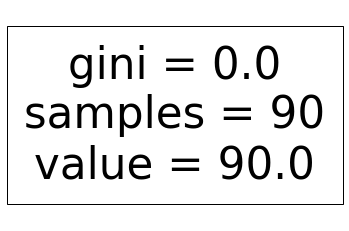

In [ ]:
# clf.predict_proba([[2., 2.]])
Y_pre=clf.predict(X_test)
tree.plot_tree(clf) 

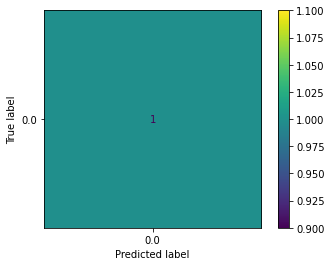

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

In [ ]:
from sklearn.metrics import recall_score, precision_score
recall_score(Y_test, Y_pre, pos_label=0)
precision_score(Y_test,Y_pre, pos_label = 0)

1.0

### The Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
Y_pre=reg.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(Y_test, Y_pre)
# plot_confusion_matrix(reg, X_test, Y_test, normalize='true')

array([[30]])

In [ ]:
from sklearn.metrics import recall_score, precision_score
recall_score(Y_test, Y_pre, pos_label=0)
precision_score(Y_test,Y_pre, pos_label = 0)

1.0

## The Neural Network

In [ ]:
d_test["true"]=np.zeros(len(d_test["tweet"]))

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
d_test= d_test.filter(items = ['marks', 'similar', 'sentiment',"before_agency","true"])

In [ ]:
d_test

,marks,similar,sentiment,before_agency,true
0,0,1,0.076923,0,0.0
1,1,1,0.166667,0,0.0
2,1,0,0.000000,0,0.0
3,0,1,0.000000,0,0.0
4,0,1,0.142857,0,0.0
...,...,...,...,...,...
115,0,1,0.058824,0,0.0
116,1,1,0.000000,1,0.0
117,0,1,0.071429,0,0.0
118,0,1,0.000000,1,0.0


In [ ]:
Y = d_test.true.values
n_f=4
X = d_test.drop('true', axis=1).values
print(X.shape)
X = X.reshape(-1, n_f)

(120, 4)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
print(X_train.shape)

(90, 4)


In [ ]:
model = models.Sequential()
model.add(layers.Dense(150,input_dim=n_f,activation="relu" ))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss=tf.keras.losses.mean_squared_error)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               750       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [ ]:
history = model.fit(X_train,Y_train,verbose=1 ,epochs=8, validation_data = (X_test, Y_test))

Epoch 1/8
3/3 [==============================] - 0s 54ms/step - loss: 0.2523 - val_loss: 0.2398
Epoch 2/8
3/3 [==============================] - 0s 7ms/step - loss: 0.2351 - val_loss: 0.2227
Epoch 3/8
3/3 [==============================] - 0s 7ms/step - loss: 0.2176 - val_loss: 0.1992
Epoch 4/8
3/3 [==============================] - 0s 7ms/step - loss: 0.1923 - val_loss: 0.1644
Epoch 5/8
3/3 [==============================] - 0s 7ms/step - loss: 0.1557 - val_loss: 0.1163
Epoch 6/8
3/3 [==============================] - 0s 7ms/step - loss: 0.1074 - val_loss: 0.0638
Epoch 7/8
3/3 [==============================] - 0s 7ms/step - loss: 0.0589 - val_loss: 0.0241
Epoch 8/8
3/3 [==============================] - 0s 7ms/step - loss: 0.0253 - val_loss: 0.0068


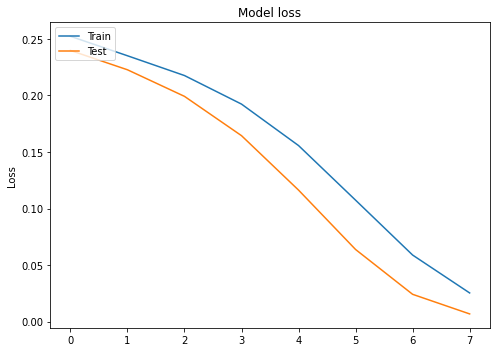

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

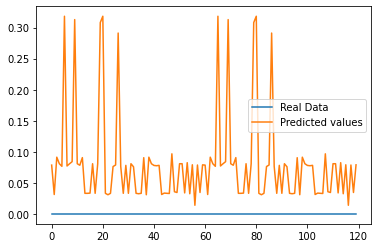

In [ ]:
Y_fut_predicted = model.predict(X)
plt.plot(Y, label = 'Real Data')
plt.plot(Y_fut_predicted, label = 'Predicted values')
plt.legend(loc=0)
plt.show()

## Notes(Important)

۱ 

من اول فکر میکردم که بیایم این کار رو کنیم که چند تا خبرگذاری رو بگیریم بعد اینا رو تو خودشون لیبل بندی کنیم بعد لیبلی که مثلا از بین ۱۰ تا خبرگزاری ۴ تا توییت توش بود احتمالا خبر نیست و اینا بعد اونا رو حذف کنیم که فقط خبر های خبرگزاری ها رو داشته باشیم و چون فقط لیبل ها حاوی خبر هستن توییت هایی از مردم عادی که این لیبل ها بهشون میخوره هم پس خبرن و بقیه توییت های مردم عادی رو حذف میکنیم ولی الان فهمیدم که شاید کار چندان خوبی نباشه چون ممکنه مردم عادی ی توییت خبری فیک کرده باشن که چون فیکه کلااا تو خبرگزاری ها نیست اون موضوع پس اینجا به مشکل میخوریم ولی خب از اون طرف هم باید توجه داشته باشیم که وقتی میخایم از مردم خبر کرال کنیم هم نمیتونیم با کی وورد های خبرگزاری ها کرال کنیم :دی  الان چیزی که تو ذهنمه اینه که از اون ستونی که اضافه کردم به اسم مارکز و نشون میده آیا تو توییت علامت تعجب یا سوال داریم استفاده کنیم حالا نمیدونم در چه حد موثره

۲

اون عددی که من برای سیمیلاریتی گذاشتم باینریه ولی شاید کار بهتری باشه خود عدد رو بزاریم   حالا کاری نداره رو این چیزا بعدا میتونیم بحث کنیم و احتمالا کلی تغییرشون میدیم

۳

کلا میتونیم اون عدد هایی که برای تی اف ای دی اف و بقیه چیز ها گذاشتم رو تغییر بدیم   همینجوری گذاشتم

۴

من فعلا ی ستون به اسم درست اضافه کردم همرو صفر گذاشتم ولی حالا بعدن که داده تست بگیریم و دستی لیبل بزنیم درستش میکنیم   داده تستی هم که الان دارم ازش استفاده میکنم با سه چهار تا از این کی وورد های داده های بی بی سی و یورو اینا گرفتم و خب قطعا اصلا کامل نیست و باید در روز های آینده کرال کنیم و لیبل بزنیم که بتونیم ازش استفاده کنیم و مدلمون رو بهتر کنیم

۵

این شبکه عصبی رو هم فعلا همینجوری لایه هاش رو گذاشتم که بعدا که داده مون آماده شد باید بهتر کنیم لایه هاش رو و اینا

۶

من تا الان تو قسمت تی اف ای دی اف تو هر مرحله که نزدیکی کوسینوسی حساب میکنم فقط به یک توییت که نزدیک ترین هست توجه میکنم و اون رو اگه به قدر کافی نزدیک باشه لیبل مشترک میزنم    الان الان دارم فکر میکنم که در آینده نزدیک این رو تغییر بدن و هر چی خبر که از اون حدی که گذاشتم نزدیک تر باشن رو لیبل یکسان بزنم نه فقط یکیشون    فکر میکنم اینجوری خیلی منطقی تره

۷

دارم فکر میکنم که از ال دی ای جنسیم هم توی توییت های یک لیبل خاص استفاده کنیم شاید خوب شه ولی الان چیز خیلی تمیزی تو ذهنم نیست که دقیق بگم   چیزایی برای جدا کردن به دو دسته که ممکنه فیک باشه یا نه و چیزایی تو مایه های این که صرفا دسته بندی دقیق تر شه تو ذهنمه ولی هنوز دقیق نمیدونم